# My First TensorFlow Project
by Piotr Skalski <a href="https://github.com/SkalskiP">GitHub</a>

<img src='https://kaggle2.blob.core.windows.net/datasets-images/2243/3791/9384af51de8baa77f6320901f53bd26b/dataset-cover.png'>

## 1. Importing libraries and dataset

### 1.1. Importing libraries

In [74]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

<b>NOTE:</b> This notebook was created using Python 3.6.4 and TensorFlow version:

In [2]:
print('TensorFlow version: ', tf.__version__)

TensorFlow version:  1.4.0


### 1.2. Importing dataset

In [3]:
data_train = pd.read_csv('../00_Datasets/Fashion_Mnist/fashion-mnist_train.csv')
data_test = pd.read_csv('../00_Datasets/Fashion_Mnist/fashion-mnist_test.csv')

In [4]:
data_train.head(3)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0


In [5]:
data_test.head(3)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0


In [6]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data_train)))
print("- Test-set:\t\t{}".format(len(data_test)))

Size of:
- Training-set:		60000
- Test-set:		10000


### 1.3. Images classes

In [7]:
IMAGE_CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

### 1.4. Splitting dataset

In [8]:
X_train = np.array(data_train.iloc[:, 1:])
y_train = np.array(data_train.iloc[:, 0])
X_test = np.array(data_test.iloc[:, 1:])
y_test = np.array(data_test.iloc[:, 0])

### 1.5. Model settings

In [24]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

### 1.6. Quick look inside dataset

In [10]:
# Building helper-function for plotting images
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Number of rows and columns of sub-plots
    nrows = 3
    ncols = 3
    
    # Create figure with sub-plots.
    fig, axes = plt.subplots(nrows,ncols,sharex=True,sharey=True, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(IMAGE_CLASSES[cls_true[i]])
        else:
            xlabel = "True: {0}, Pred: {1}".format(IMAGE_CLASSES[cls_true[i]], IMAGE_CLASSES[cls_pred[i]])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel, size=15)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

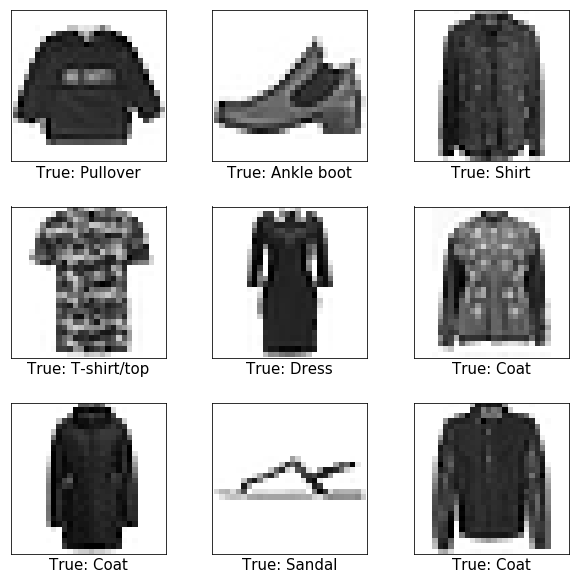

In [11]:
# Get the first images from the test-set.
images = X_train[0:9]

# Get the true classes for those images.
cls_true = y_train[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## 2. Building TensorFlow Graph

### 2.1. Building helper-functions

In [12]:
# Building helper-function for creating new variavles
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [14]:
# Building helper-function for creating a new Convolutional Layer
def new_conv_layer(input, num_input_channels, filter_size, num_filters, use_pooling=True):

    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(shape=shape)
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    layer = tf.nn.conv2d(input=input, filter=weights, strides=[1, 1, 1, 1], padding='SAME')
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        layer = tf.nn.max_pool(value=layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Rectified Linear Unit (ReLU).
    layer = tf.nn.relu(layer)

    return layer, weights

In [16]:
# Building helper-function for flattening a layer
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()
    
    num_features = layer_shape[1:4].num_elements()
    
    layer_flat = tf.reshape(layer, [-1, num_features])

    return layer_flat, num_features

In [22]:
# Building helper-function for creating a new Fully-Connected Layer
def new_fc_layer(input, num_inputs, num_outputs, use_relu=True):

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

### 2.2. Placeholder variables

In [17]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

In [18]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

In [45]:
y_true = tf.placeholder(tf.int64, shape=[None, num_classes], name='y_true')
# y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

### 2.3. Laying layers

In [46]:
layer_conv1, weights_conv1 = new_conv_layer(input=x_image, num_input_channels=num_channels,
                   filter_size=filter_size1, num_filters=num_filters1, use_pooling=True)

In [47]:
layer_conv1

<tf.Tensor 'Relu_3:0' shape=(?, 14, 14, 16) dtype=float32>

In [48]:
layer_conv2, weights_conv2 = new_conv_layer(input=layer_conv1, num_input_channels=num_filters1,
                   filter_size=filter_size2, num_filters=num_filters2, use_pooling=True)

In [49]:
layer_conv2

<tf.Tensor 'Relu_4:0' shape=(?, 7, 7, 36) dtype=float32>

In [50]:
layer_flat, num_features = flatten_layer(layer_conv2)

In [51]:
layer_flat

<tf.Tensor 'Reshape_5:0' shape=(?, 1764) dtype=float32>

In [52]:
num_features

1764

In [53]:
layer_fc1 = new_fc_layer(input=layer_flat, num_inputs=num_features, num_outputs=fc_size, use_relu=True)

In [54]:
layer_fc1

<tf.Tensor 'Relu_5:0' shape=(?, 128) dtype=float32>

In [55]:
layer_fc2 = new_fc_layer(input=layer_fc1, num_inputs=fc_size, num_outputs=num_classes, use_relu=False)

In [56]:
layer_fc2

<tf.Tensor 'add_7:0' shape=(?, 10) dtype=float32>

### 2.4. Predicted Class

In [57]:
y_pred = tf.nn.softmax(layer_fc2)

In [58]:
y_pred_cls = tf.argmax(y_pred, axis=1)

### 2.5 Cost-function to be optimized

In [59]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=y_true)

In [60]:
cost = tf.reduce_mean(cross_entropy)

In [61]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

### 2.6. Performance Measures

In [63]:
correct_prediction = tf.equal(y_pred_cls, y_true)

In [64]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## 3. TensorFlow Run

In [65]:
session = tf.Session()

### 3.1. Building helper-functions

In [67]:
train_batch_size = 64

In [93]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
#         x_batch, y_true_batch = data.train.next_batch(train_batch_size)
        shuffle_indices = np.random.permutation(np.arange(train_batch_size))
        x_batch = X_train[shuffle_indices]
        y_true_batch = y_train[shuffle_indices]

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [94]:
# Helper-function to plot example errors
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [95]:
# Helper-function to plot confusion matrix
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [96]:
# Helper-function for showing the performance
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## 3. Performance after 100 optimization iterations

In [97]:
optimize(num_iterations=100) # We already performed 1 iteration above.

ValueError: Cannot feed value of shape (64,) for Tensor 'y_true_1:0', which has shape '(?, 10)'

## 4. References

1. <a href="https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb">TensorFlow Tutorial #02 Convolutional Neural Network</a>